# 共通の準備

In [1]:
#http://d.hatena.ne.jp/naraba/20121201/p1
#http://web.mit.edu/music21/doc/usersGuide/usersGuide_01_installing.html

from music21 import *
#environment.set('musicxmlPath' , r"C:\Program Files (x86)\Finale NotePad 2012\Finale NotePad.exe")
#configure.run()
#environment.keys()
#environment.get('musicxmlPath')

楽譜を表示するためのおまじない
参考URL:https://groups.google.com/forum/#!topic/music21list/FmU6HeNm7AM

In [2]:
us = environment.UserSettings()
#us.create()
us['musicxmlPath'] = r'C:\Program Files (x86)\MuseScore 2\bin\MuseScore.exe'
us['musescoreDirectPNGPath'] = r'C:\Program Files (x86)\MuseScore 2\bin\MuseScore.exe'
%load_ext music21.ipython21

# 素材のロード

In [3]:
s_jazz = converter.parse('C:/Users/t/PycharmProjects/deepjazz_in_a_file/midi/original_metheny.mid')

meter.py: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter.py: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 10 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/

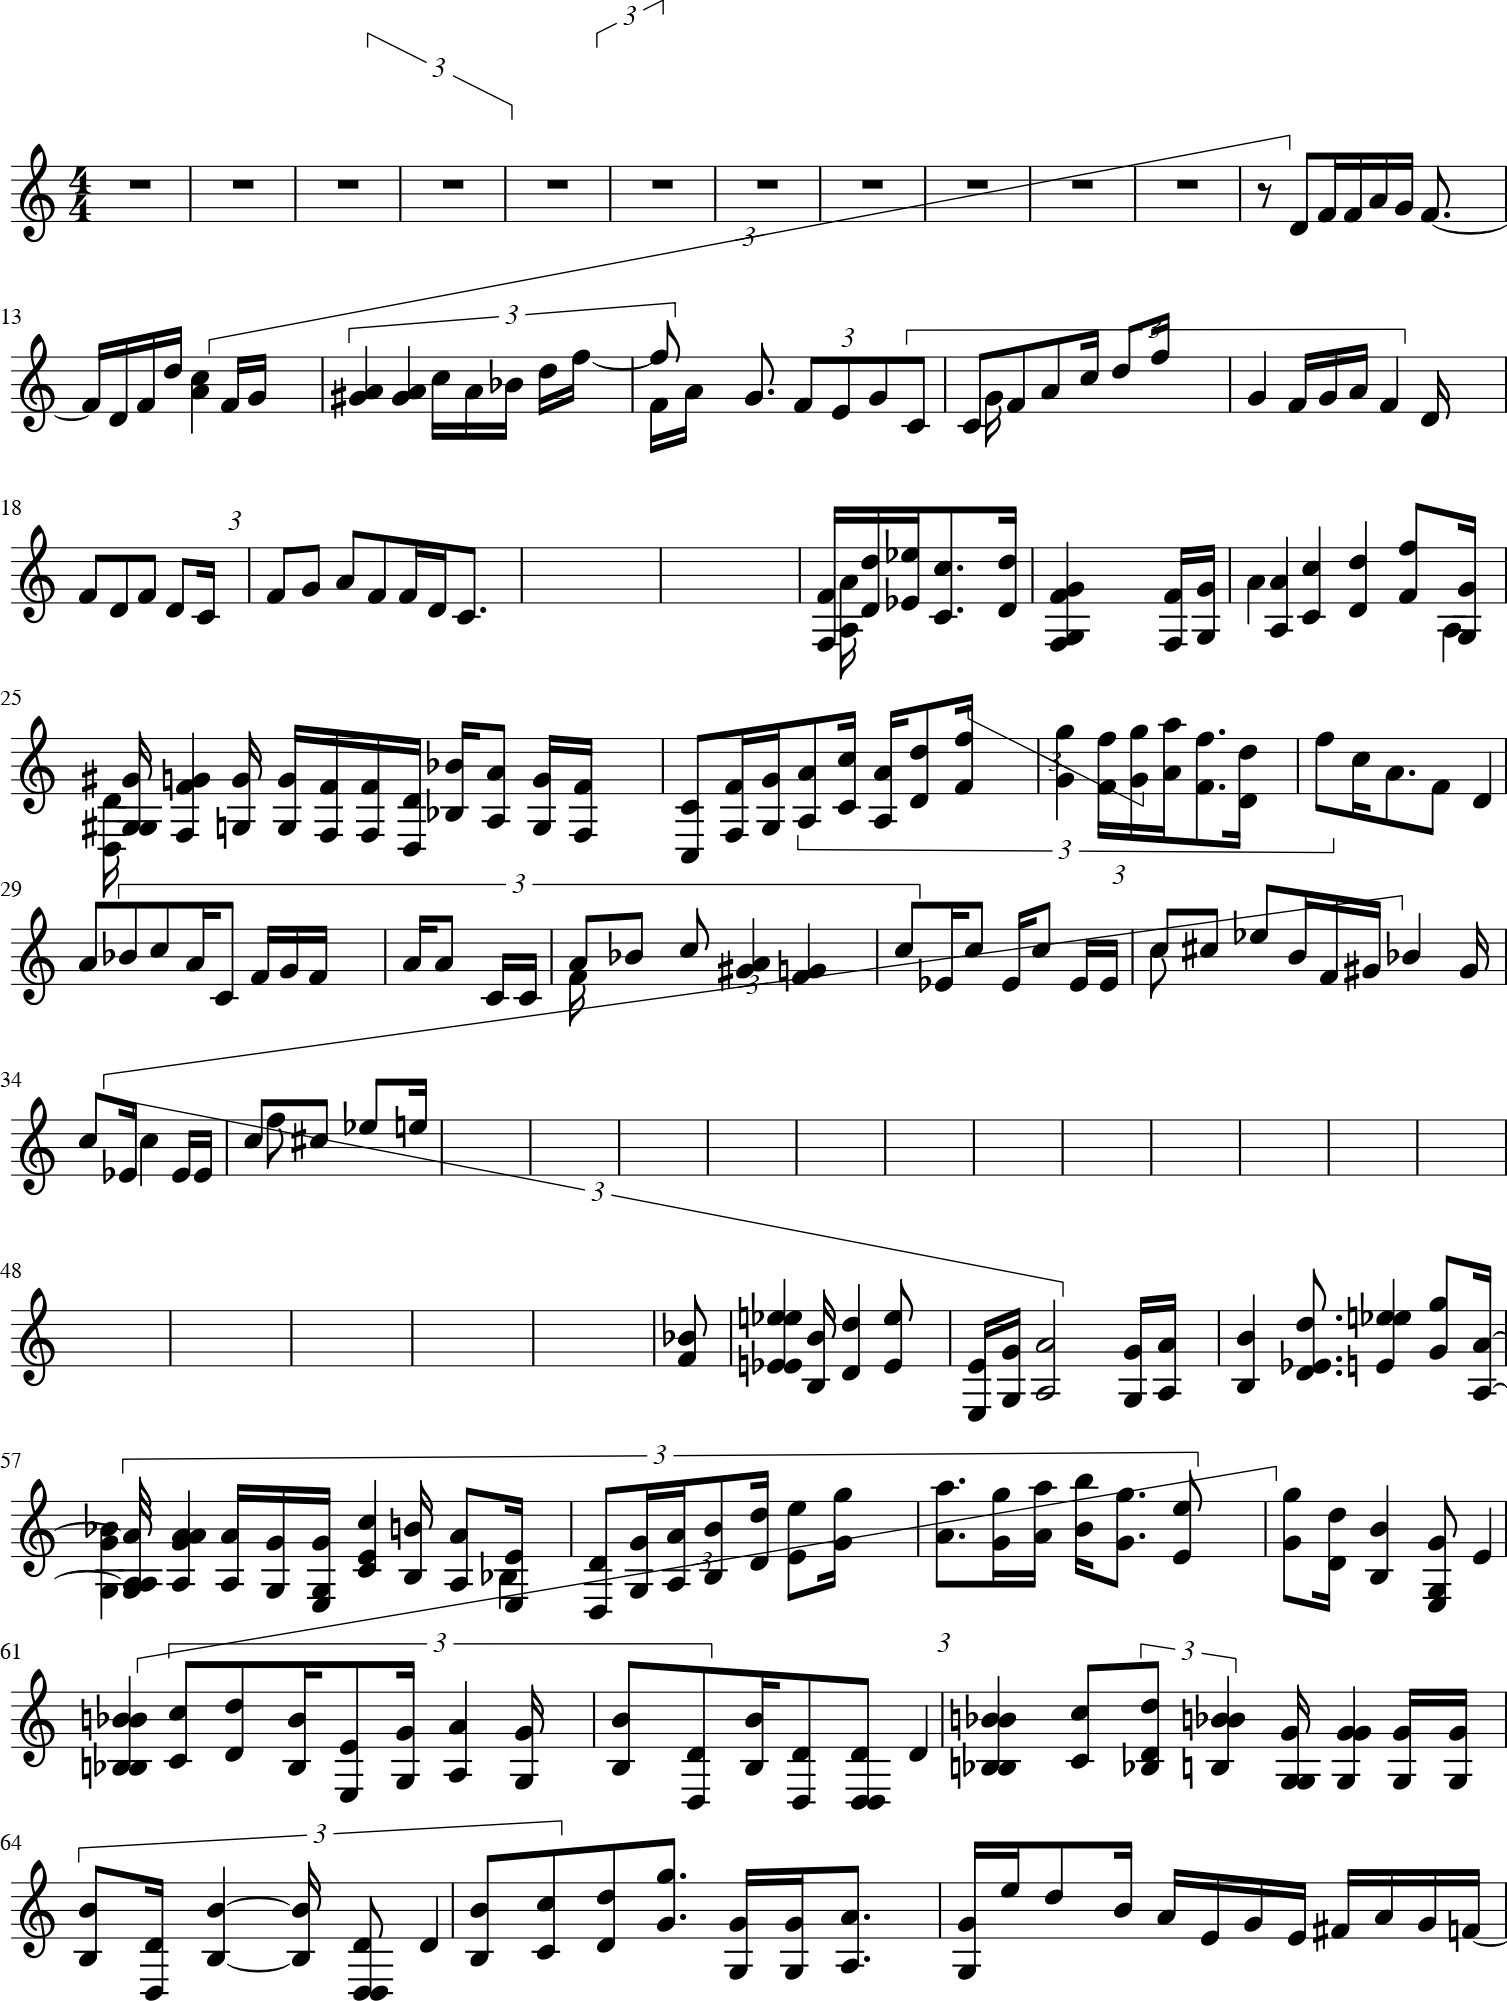

In [6]:
s_jazz[5].show()

midiでの演奏のさせ方：

In [ ]:
sp = midi.realtime.StreamPlayer(s_jazz)
sp.play()

midi.base.py: WARNING: Conversion error for <MidiEvent PROGRAM_CHANGE, t=0, track=3, channel=3>: Got incorrect data for <MidiEvent PROGRAM_CHANGE, t=0, track=3, channel=3> in .data: None,cannot parse Program Change; ignored.
midi.base.py: WARNING: Conversion error for <MidiEvent PROGRAM_CHANGE, t=0, track=4, channel=3>: Got incorrect data for <MidiEvent PROGRAM_CHANGE, t=0, track=4, channel=3> in .data: None,cannot parse Program Change; ignored.
midi.base.py: WARNING: Conversion error for <MidiEvent PROGRAM_CHANGE, t=0, track=5, channel=3>: Got incorrect data for <MidiEvent PROGRAM_CHANGE, t=0, track=5, channel=3> in .data: None,cannot parse Program Change; ignored.
midi.base.py: WARNING: Conversion error for <MidiEvent PROGRAM_CHANGE, t=0, track=9, channel=3>: Got incorrect data for <MidiEvent PROGRAM_CHANGE, t=0, track=9, channel=3> in .data: None,cannot parse Program Change; ignored.
midi.base.py: WARNING: Conversion error for <MidiEvent PROGRAM_CHANGE, t=0, track=10, channel=3>: Go

In [4]:
melody_stream = s_jazz[5]     # For Metheny piece, Melody is Part #5.
melody1, melody2 = melody_stream.getElementsByClass(stream.Voice)

voiceを複数持つパートをチェック：

In [5]:
[len(x.getElementsByClass(stream.Voice)) for x in s_jazz]

[5, 0, 4, 4, 0, 2, 4, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]

part 5はふたつのvoiceを持つ

## stream.Voiceの表示のさせ方

In [ ]:
tmp_stream = stream.Score()
tmp_stream.insert(melody1)
tmp_stream.show()

## ふたつのvoiceをひとつにまとめてmelody_voiceに収納：

In [6]:
for j in melody2:
    melody1.insert(j.offset, j)

melody_voice = melody1 

melody_voiceに足りない部品を追加：

In [7]:
for i in melody_voice:
    if i.quarterLength == 0.0:
        i.quarterLength = 0.25

melody_voice.insert(0, instrument.ElectricGuitar())
#melody_voice.insert(0, key.KeySignature(sharps=1, mode='major'))
melody_voice.insert(0, key.KeySignature(1))

これを見るには：

meter.py: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter.py: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter.py: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.bea

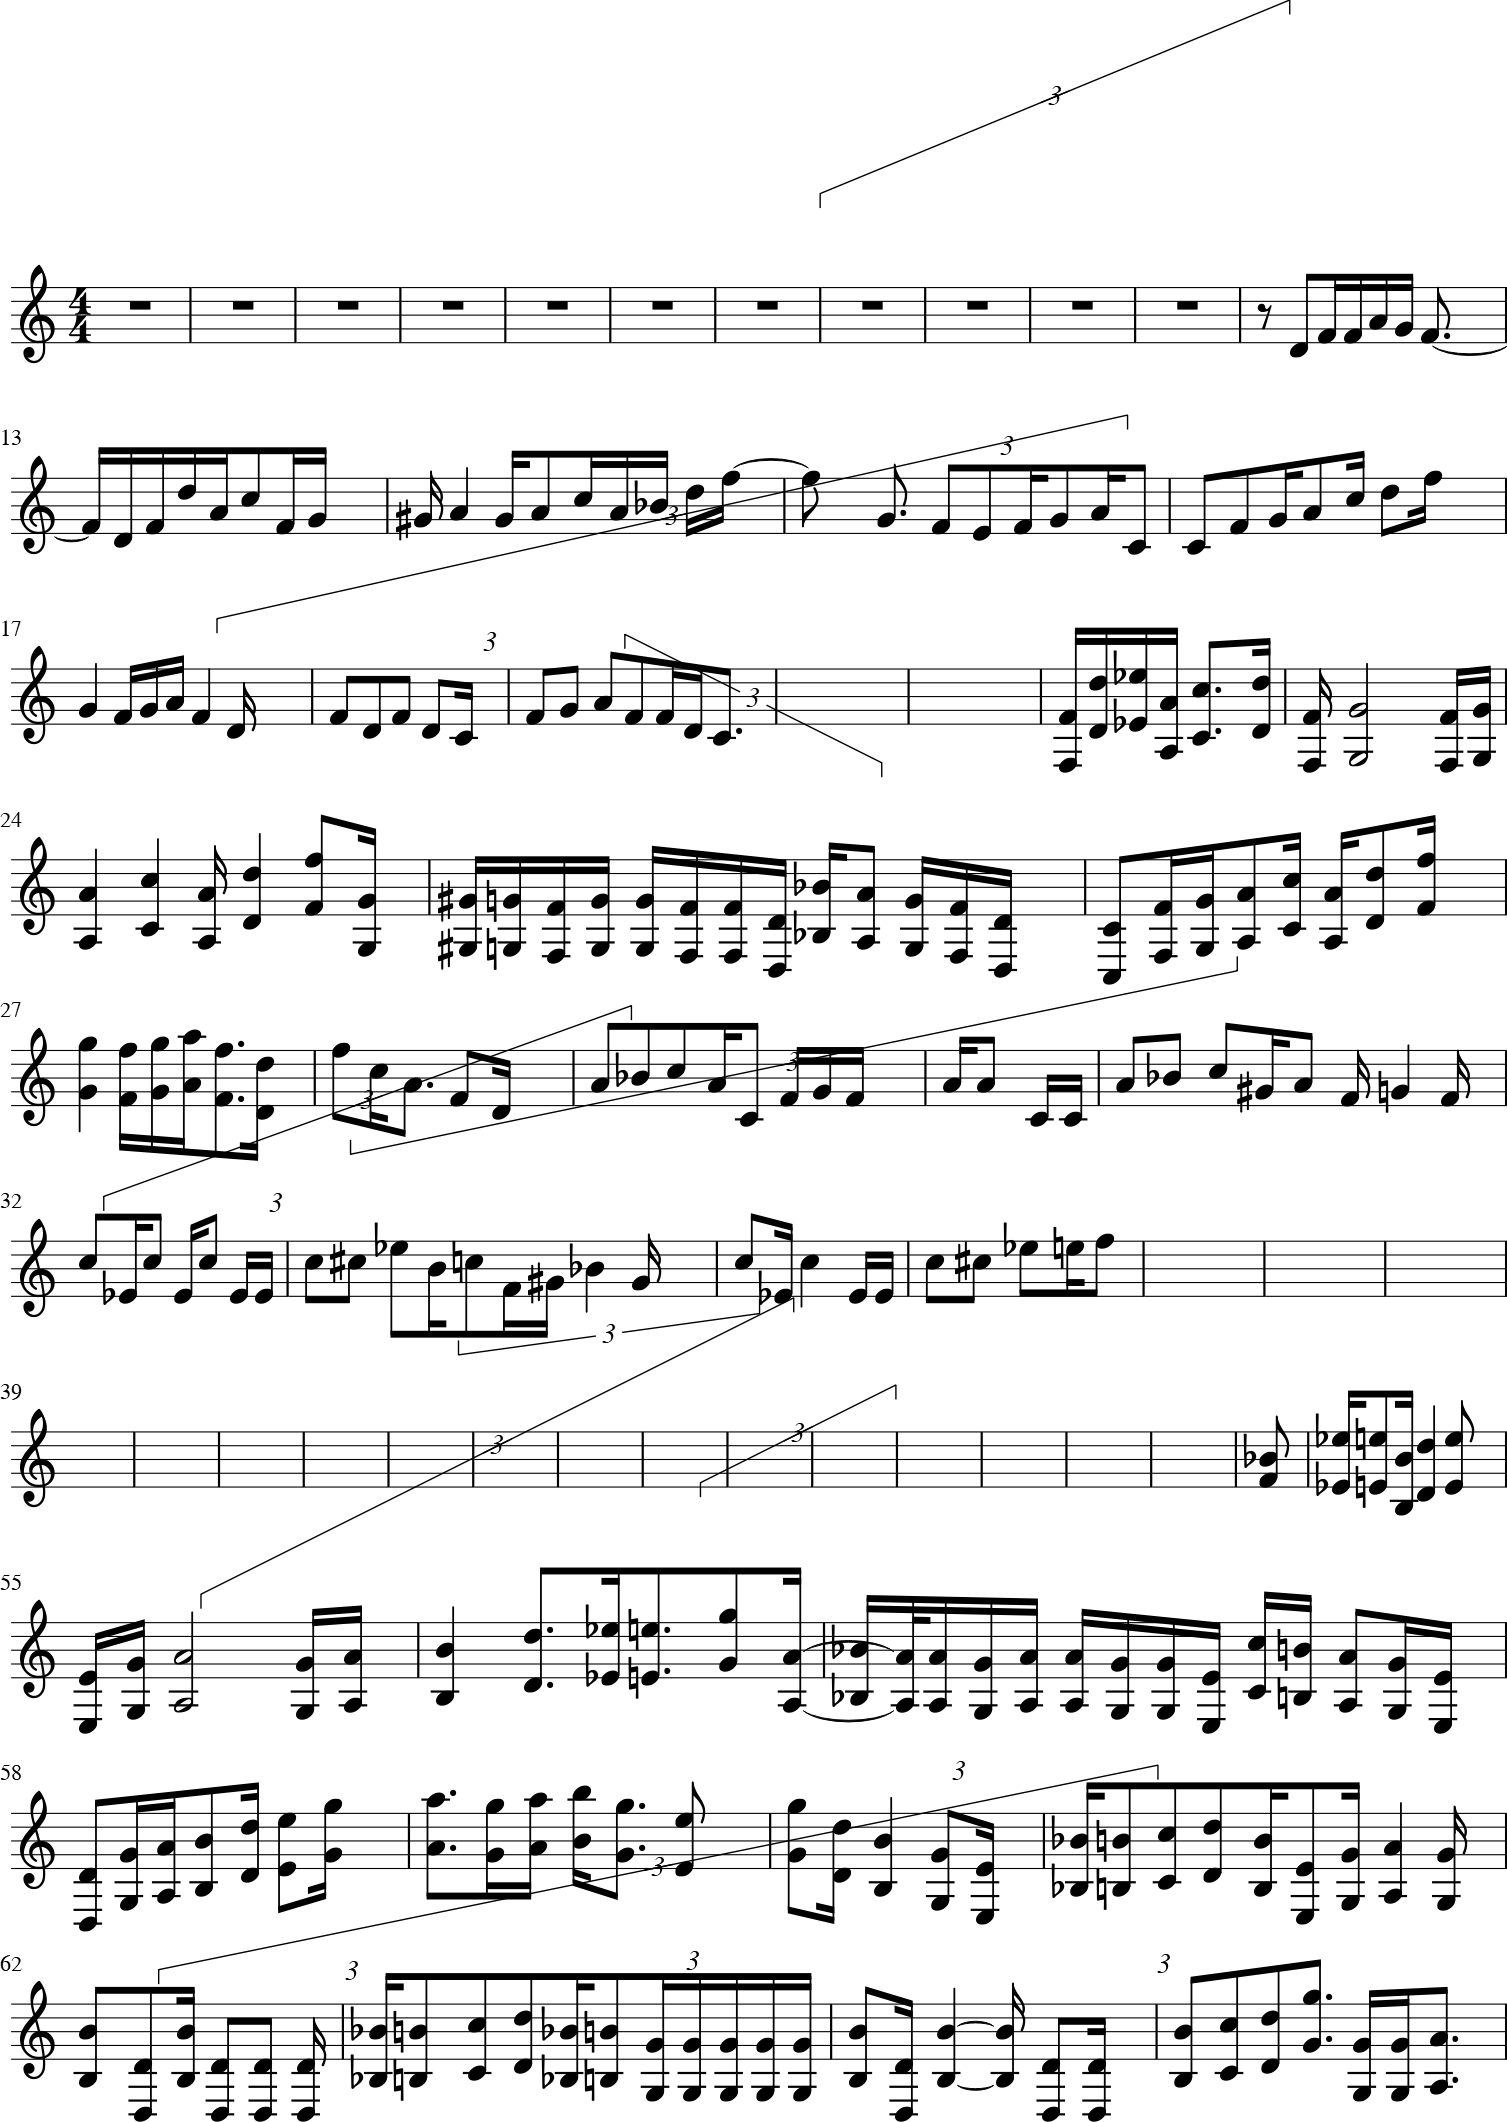

In [8]:
tmp_stream = stream.Score()
tmp_stream.insert(melody_voice)
tmp_stream.show()

## 表示がうまくいかない例

上記の代わりに以下ではだめ？？？==>だめっぽい

以下結構時間をかけたのちエラーが返る例：

In [ ]:
tmp_stream = stream.Stream()
tmp_score = stream.Score()
tmp_voice = stream.Voice()
tmp_score.insert(melody_stream.flat)

tmp_score.show()

## 特定のパートからcomp_streamを定義

以下のようにほぼすべてのパートを使ってしまうと後でエラーになる：

In [ ]:
comp_stream = stream.Voice()
comp_stream.append([j.flat for i, j in enumerate(s_jazz) if i is not 5])

以下であればOK:

In [ ]:
partIndices = [0, 1, 6, 7]
comp_stream = stream.Voice()
comp_stream.append([j.flat for i, j in enumerate(s_jazz) if i in partIndices])

以下２セルは同じようなことをやらせているつもり・・

In [ ]:
full_stream = stream.Voice()

for i in range(len(comp_stream)):
    full_stream.append(comp_stream[i])

full_stream.append(melody_voice)

In [ ]:
full_stream = comp_stream
full_stream.append(melody_voice)

## 特定のtime windowをsolo_streamとして抽出

In [ ]:
solo_stream = stream.Voice()
solo_start = 476
solo_end = 648#548

for part in full_stream:
    curr_part = stream.Part()
    curr_part.append(part.getElementsByClass(instrument.Instrument))
    curr_part.append(part.getElementsByClass(tempo.MetronomeMark))
    curr_part.append(part.getElementsByClass(key.KeySignature))
    curr_part.append(part.getElementsByClass(meter.TimeSignature))
    curr_part.append(part.getElementsByOffset(solo_start, solo_end,
                                              includeEndBoundary=True))
    cp = curr_part.flat
    solo_stream.insert(cp)


できたstreamは直接楽譜化できないので、scoreに加えてから見る：

In [ ]:
tmp_stream = stream.Score()
tmp_stream.insert(solo_stream)
#tmp_stream.insert(solo_start , solo_stream)
tmp_stream.show()

## 演奏させてチェック

In [ ]:
sp = midi.realtime.StreamPlayer(tmp_stream)
sp.play()

## いろいろな楽器が含まれているsolo_streamから和音パートであるパート０のみ取り出す：

In [ ]:
chordStream = solo_stream[0]

和音のみ取り出して
- 音に分解しnotesに格納
- offsetゼロからに詰める：

In [ ]:
offsets = list()
notes = list()
for c in chordStream:
    if False:
        c = chordStream[2]
    if isinstance(c , chord.Chord):
        for p in c.pitches:
            if False:
                p = c.pitches[0]
            run_note = note.Note(p._getNameWithOctave())
           # run_note.volume.velocity = 200
            offsets.append(c.offset)
            notes.append(run_note)
run_sub = min(offsets)
offsets = [o - run_sub for o in offsets]
a_part = stream.Part()
for i, n in enumerate(notes):
    a_part.insert(offsets[i], n)


演奏させてチェック：

In [ ]:
tmp_stream = stream.Score()
tmp_stream.insert(a_part)
sp = midi.realtime.StreamPlayer(tmp_stream)
sp.play()

楽譜はどうもうまく表示されない（同じoffsetの音がずれされて表示される？）:

In [ ]:
a_part.show()

# ランダム化

## 複数の楽器を指定して、それぞれに対応するパートを準備する：

In [ ]:
import numpy as np
N = 4

instruments = [instrument.ElectricGuitar() ,
               instrument.Piano() ,
               instrument.Cowbell() ,
               instrument.Flute()]
#instruments = [instrument.Flute() , instrument.Flute() , instrument.Flute() , instrument.Flute()]



multi_parts = [stream.Part() for i in range(N)]
for i in range(len(multi_parts)):
    #multi_parts[i].append(instruments[i])
    multi_parts[i].insert(instruments[i])

## ランダム化メインパート
notesにある音を
- ランダムに全音上げる
- ランダムにvelocity（音量？）を変化させる
- ランダムに楽器パートに割り振る

In [ ]:
for i, n in enumerate(notes):
    j = np.random.randint(0 , N)
    #multi_parts[j].insert(offsets[i] + np.random.random() * 0.2 , n)
    #multi_parts[j].insert(offsets[i], n)
    if np.random.randint(0,2) == 1:
        n = n.transpose('m3')
    n.volume.velocity = 200 * (1 + np.random.random())
    multi_parts[j].insert(offsets[i] + float(np.random.randint(0, 2)) * 0.5, n)

## scoreに格納

In [ ]:
run_score = stream.Score()
bpm = 180
run_score.insert(0.0, tempo.MetronomeMark(number=bpm))
#http://web.mit.edu/music21/doc/moduleReference/moduleStream.html
for i in range(len(multi_parts)):
    if False:
        i = 0
    run_score.insert(0 , multi_parts[i])

## 結果の確認

In [ ]:
#run_score.show('midi')
sp = midi.realtime.StreamPlayer(run_score)
sp.play()

In [ ]:
run_score.show()

# 記述統計

In [ ]:
note_cents = [interval.notesToChromatic(note.Note("C0") , x).cents /100. for x in notes]

In [ ]:
import pandas as pd

In [ ]:
df_notes = pd.DataFrame({"cent" : note_cents , "offset":offsets})

In [ ]:
import plotly.offline as offline
offline.init_notebook_mode()

In [ ]:
df_notes.describe()

## plotlyで描画
https://plot.ly/python/getting-started/
https://plot.ly/python/line-and-scatter/

In [ ]:
import plotly.graph_objs as go

trace = go.Scatter(
    x = df_notes['offset'].tail(400),
    y = df_notes['cent'].tail(400),
mode = 'lines')

In [ ]:
offline.iplot([trace])

## part毎に色分けして描画

In [ ]:
tmp = full_stream[1].getElementsByClass(instrument.Instrument)

In [ ]:
tmp2 = tmp[0]

In [ ]:
full_stream[1].getInstrument().instrumentName

In [ ]:
part2offset = list()
part2note = list()
traces = list()
for s in full_stream:
    offsets = list()
    notes = list()
    for c in s:
        if False:
            c = chordStream[2]
        if isinstance(c , chord.Chord):
            for p in c.pitches:
                if False:
                    p = c.pitches[0]
                run_note = note.Note(p._getNameWithOctave())
               # run_note.volume.velocity = 200
                offsets.append(float(c.offset))
                notes.append(run_note)
        if isinstance(c , note.Note):
            offsets.append(float(c.offset))
            notes.append(c)
    note_cents = [interval.notesToChromatic(note.Note("C0") , x).cents /100. for x in notes]
    run_trace = go.Scatter(
        x = np.array(offsets) ,
        y = np.array(note_cents) ,
        mode = 'lines')
    traces.append(run_trace)
    part2offset.append(offsets)
    part2note.append(notes)


In [ ]:
c


In [ ]:
offline.iplot(traces)

## part内の和音を分解してtragectoryを表示

In [ ]:
c

In [ ]:
part2offset = list()
part2note = list()
traces = list()
names = list()
for s in full_stream:
    n_line = 1
    for c in s:
        if isinstance(c , chord.Chord):
            n_line = max(n_line , len(c))

        
    offsets = [list() for i in range(n_line)]
    notes = [list() for i in range(n_line)]
    run_instrument = s.getInstrument().instrumentName

    for c in s:
        if False:
            c = chordStream[2]
        if isinstance(c , chord.Chord):
            for i , p in enumerate(c.pitches):
                if False:
                    p = c.pitches[0]
                run_note = note.Note(p._getNameWithOctave())
               # run_note.volume.velocity = 200
                offsets[i].append(float(c.offset))
                notes[i].append(run_note)
        if isinstance(c , note.Note):
            offsets[0].append(float(c.offset))
            notes[0].append(c)
    for i in range(n_line):
        note_cents = [interval.notesToChromatic(note.Note("C0") , x).cents /100. for x in notes[i]]
        run_trace = go.Scatter(
            x = np.array(offsets[i]) ,
            y = np.array(note_cents) ,
            mode = 'lines' ,
            name = run_instrument + str(i))
        traces.append(run_trace)
        part2offset.append(offsets[i])
        part2note.append(note_cents)
        names.append(run_instrument)

In [ ]:
offline.iplot(traces)

# Kerasにかけてみる

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import SGD

## まずはナイーブに実数として極めて冗長な表現でやってみる

### データ成型

In [ ]:
list_offsets = list()
for p in part2offset:
    list_offsets.extend(p)

list_offsets = list(set(list_offsets))

In [ ]:

list_offsets = np.sort(list_offsets)

In [ ]:
list_offsets[0:10]

In [ ]:
i = 0
X_raw = np.array([[part2note[i][part2offset[i].index(o)] if o in part2offset[i] else 0 for o in list_offsets] for i in range(len(part2note))] )

In [ ]:
X_raw = X_raw.transpose()

In [ ]:
X_raw.shape

In [ ]:
y = X_raw[1: , ]

In [ ]:
X = X_raw[:-1 , ]

In [ ]:
raw_mean = X_raw.mean(axis = 0)
raw_sd = X_raw.std(axis = 0)

In [ ]:
X = (X - raw_mean) / raw_sd
y = (y - raw_mean) / raw_sd

### model定義

まずは

In [ ]:
model = Sequential()

In [ ]:
N_input = len(part2note)

In [ ]:
model.add(Dense(20 , input_dim=N_input))

In [ ]:
model.add(Activation('relu'))

In [ ]:
model.add(Dense(N_input))

In [ ]:
model.compile(loss='mean_squared_error' , optimizer=SGD())

In [ ]:
run_fit = model.fit(X, y, nb_epoch=10, validation_split=0.2 , verbose=2)#

このモデルは一応動くことは動くがデータ数に対して自由度が高すぎて明らかによろしくない・・・

そもそもdeep jazzではメロディパートしか推定していない（？）

# 以下素材

In [ ]:
type(melody_stream)

In [ ]:
type(melody1)

In [ ]:
type(melody1).mro()

In [ ]:
[x.offset for x in melody1.getElementsByClass(note.Note)]

In [ ]:
s_bach = corpus.parse('bach/bwv65.2.xml')

In [ ]:
len(s_bach)

In [ ]:
s_bach[1].show()
